## Data Analysis on the United Kingdom Customers Dataset

### PayPal Digital Marketing Analytics take-home case
### Author: RAKESH HARISH
#### Date: May 23 and May 24, 2019

### This Notebook contains two sections.

#### 1) Data analysis section: Python Code with necessary insights comments
#### 2) Write-up section: Summary of my analysis

### Section 1: Data Analysis

Importing the necessary libraries for the analysis

In [1]:
import pandas as pd 
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
import gc
import datetime
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
color = sns.color_palette()

In [2]:
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')
df = df[df['Country'].str.contains("United Kingdom")].reset_index(drop=True)
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format="%m/%d/%Y %H:%M")

Studying the data comprehensively to start with...

In [3]:
pandas_profiling.ProfileReport(df)

Number of variables,8
Number of observations,495478
Total Missing (%),3.4%
Total size in memory,30.2 MiB
Average record size in memory,64.0 B
Numeric,3
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null datetime64[ns]
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 30.2+ MB


## Exploratory Data Analysis (EDA)

Before solving the three questions and working on other analysis, lets explore the data and get some idea out of it.
Let us also focus on cleaning the data and adding the additional columns for the future analysis.


First checking for nulls and removing them.

In [5]:
df.isnull().sum().sort_values(ascending=False)

CustomerID     133600
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [6]:
df[df.isnull().any(axis=1)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
586,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1298,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1299,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1300,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1301,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [7]:
df= df.dropna(subset=['CustomerID'])

In [8]:
df.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3661,19857,3950


From the dataset description, we understand that there are many "Cancelled Orders" in the dataset. In order to perform accurate sales analysis, lets us remove the cancelled orders which has "C" in the Invoice No. For these cancelled orders the quantity and $$$ are in negatives.

In [11]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.sort_values('Number of products', ascending=False).reset_index(drop=True)

,CustomerID,InvoiceNo,Number of products
0,14096.0,576339,542
1,14096.0,579196,533
2,14096.0,580727,529
3,14096.0,578270,442
4,14096.0,573576,435
5,14096.0,567656,421
6,14769.0,567183,399
7,14096.0,575607,377
8,14096.0,571441,364
9,14096.0,570488,353


In [12]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print("We have ",n1, " cancelled orders.")
print('Percent of canceled orders: {}/{} = {:.2f}% '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12747.0,537215,7,0
3,12747.0,538537,8,0
4,12747.0,541677,5,0


We have  3208  cancelled orders.
Percent of canceled orders: 3208/19857 = 16.16% 


In [13]:
#exploring the unique values of each attribute
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products: ",df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(df['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )
print('Number of countries: ',df['Country'].nunique(), ' - considered only U.K.')

Number of transactions:  19857
Number of products:  3661
Number of customers: 3950
Percentage of customers NA:  0.0 %
Number of countries:  1  - considered only U.K.


So there are about 16% of Cancelled Orders in the dataset. Let us remove them now.

In [14]:
cancelled_orders = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
121,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
134,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
201,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
202,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
203,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [15]:
cancelled_orders[cancelled_orders['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [16]:
# Item sale with Quantity <=0 or unitPrice < 0
#There is 10626 transaction that have negative quantity or unitPrice

df1=df[(df['Quantity']>0) & (df['UnitPrice']>0)].reset_index(drop=True)
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [17]:
df1['CustomerID'] = df1['CustomerID'].astype('int64')

In [18]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,12.013795,2.963994,15552.486392
std,189.267956,17.862655,1594.527150
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


Next lets us remove the duplicates present in the data.

In [19]:
df1.duplicated().sum()

5118

In [20]:
duplicateRowsDF = df1[df1.duplicated()]
duplicateRowsDF

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
472,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
482,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
492,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
494,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
510,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920,United Kingdom
542,536412,22273,FELTCRAFT DOLL MOLLY,1,2010-12-01 11:49:00,2.95,17920,United Kingdom
544,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,2010-12-01 11:49:00,3.75,17920,United Kingdom
549,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1,2010-12-01 11:49:00,2.10,17920,United Kingdom
553,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920,United Kingdom
555,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2,2010-12-01 11:49:00,3.75,17920,United Kingdom


In [21]:
df2 = df1.drop_duplicates().reset_index(drop=True)
df2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


In [22]:
df2.duplicated().sum()

0

In [23]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Adding additional columns for the ease of analysis.

In [24]:
df2.insert(loc=5, column='year_month', value=df2['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df2.insert(loc=6, column='month', value=df2.InvoiceDate.dt.month)
df2.insert(loc=7, column='quarter', value=df2.InvoiceDate.dt.quarter)
df2.insert(loc=8, column='day', value=(df2.InvoiceDate.dt.dayofweek)+1)
df2.insert(loc=9, column='hour', value=df2.InvoiceDate.dt.hour)
df2.insert(loc=10, column='Week', value=df2['InvoiceDate'].apply(lambda x: x.strftime('%W')))
df2.insert(loc=11, column='datepart', value=df2['InvoiceDate'].apply(lambda x: x.strftime('%d')))
df2.insert(loc=12, column='Year', value=df2['InvoiceDate'].map(lambda x: x.year))
df2.insert(loc=14, column='Revenue', value=df2["Quantity"]* df2["UnitPrice"])

In [25]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,year_month,month,quarter,day,hour,Week,datepart,Year,UnitPrice,Revenue,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,201012,12,4,3,8,48,01,2010,2.55,15.30,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,201012,12,4,3,8,48,01,2010,3.39,20.34,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,201012,12,4,3,8,48,01,2010,2.75,22.00,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,201012,12,4,3,8,48,01,2010,3.39,20.34,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,201012,12,4,3,8,48,01,2010,3.39,20.34,17850,United Kingdom


## Questions to explore for this case:

If you are on the digital marketing team of the online retailer in question below, please provide insights on the below business questions with the data provided.

 

#### Data analysis section:
Focus on the UK customers in the data set for this study and provide customer behavior insights for a few interesting groups of customers:

* Frequent transactors – let’s say we define this group to be customers who have made at least one transaction every quarter during the period of 2010;

* Multi-product transactors – let’s define this group to be any customer who has purchased at least 3 different products or more over the course of 2010-2011.

* Highest value customers – focus on top 20% of customers in terms of revenue in 2010 (total revenue for each customer = quantity x transaction price for the period 2010)
 

Are there any transaction behaviors that are common/frequently occurring for these groups that are different relative to the average customer?
Demonstrate how can we effectively visualize and communicate these data insights

#### Assumption made:
    
####   - For Question1, I assumed it is for the period 2011 connsidering 2010 has just one month's data. I assumed it was a typo.
####   - For Question2, no assumption. Calculated for full data 2010-2011 period.
####   - For Question3, again since 2010 had very limited data of one month, I assumed and analysed for the year 2011 instead.

In [26]:
# Filter to get df2 for 2011
df2_2011 = df2.loc[df2["Year"] == 2011].reset_index(drop=True)

In [27]:
# Question 1
df2_2011_filter = df2_2011.groupby(['CustomerID', 'quarter']).size().groupby("CustomerID").size().reset_index()
q1_result = df2_2011_filter[df2_2011_filter[0]==4]["CustomerID"].reset_index()

In [28]:
print("The Frequent transactors are:")
q1_result["CustomerID"]

The Frequent transactors are:


0      12747
1      12748
2      12826
3      12836
4      12839
5      12841
6      12843
7      12867
8      12877
9      12901
10     12909
11     12921
12     12931
13     12935
14     12937
15     12948
16     12955
17     12957
18     12971
19     12989
20     12993
21     12997
22     13001
23     13004
24     13012
25     13014
26     13018
27     13021
28     13026
29     13047
       ...  
562    18016
563    18041
564    18044
565    18055
566    18061
567    18065
568    18069
569    18075
570    18077
571    18092
572    18097
573    18102
574    18109
575    18118
576    18144
577    18145
578    18161
579    18171
580    18172
581    18177
582    18198
583    18219
584    18223
585    18225
586    18226
587    18229
588    18230
589    18245
590    18257
591    18283
Name: CustomerID, Length: 592, dtype: int64

In [29]:
# Question 2
q2_filter = df2.groupby(['CustomerID', 'StockCode']).size().groupby("CustomerID").size().reset_index()
q2_result = q2_filter[q2_filter[0]>3]["CustomerID"].reset_index()

In [30]:
print("Multi-product transactors are:")
q2_result.CustomerID

Multi-product transactors are:


0       12747
1       12748
2       12749
3       12820
4       12821
5       12822
6       12824
7       12826
8       12827
9       12828
10      12829
11      12830
12      12831
13      12832
14      12833
15      12834
16      12836
17      12837
18      12838
19      12839
20      12840
21      12841
22      12842
23      12843
24      12844
25      12845
26      12847
27      12849
28      12851
29      12852
        ...  
3690    18239
3691    18240
3692    18241
3693    18242
3694    18245
3695    18248
3696    18249
3697    18250
3698    18251
3699    18252
3700    18255
3701    18257
3702    18259
3703    18260
3704    18261
3705    18262
3706    18263
3707    18265
3708    18269
3709    18270
3710    18272
3711    18274
3712    18276
3713    18277
3714    18278
3715    18280
3716    18281
3717    18282
3718    18283
3719    18287
Name: CustomerID, Length: 3720, dtype: int64

In [31]:
q3_df2 = df2_2011
q3_df2["Revenue"] = q3_df2["Quantity"]*q3_df2["UnitPrice"]

In [32]:
q3_filter = q3_df2.groupby(['CustomerID'])[["Revenue"]].sum().reset_index().sort_values(by=['Revenue'],ascending=False).reset_index(drop=True)
count = math.floor(len(q3_filter)*0.2)
q3_result = q3_filter.loc[:count-1]

In [33]:
print("Highest value customers are:")
q3_result

Highest value customers are:


,CustomerID,Revenue
0,18102,231822.69
1,17450,192361.95
2,16446,168472.50
3,17511,84351.30
4,12346,77183.60
5,16029,67738.32
6,14096,65164.79
7,16684,63540.16
8,13694,62142.58
9,15311,57972.74


## Exploring other transaction behaviors by visualizing a few and extracting insights of out it

#### Customers place more orders in the second half of the year. Nov is the month with highest orders followed by Oct and Sept. Since we do not have full Dec month's data for both 2010 and 2011 let us also not discount the performance during the last month of both the years. Infact year end surge in the sales is one more indicator to stock up the fast moving items before the shopping season start sometime around Sept/Oct and Thanksgiving period.

#### The second chart below depicts the sales by quarter and we can observe a steady increase in sales Q-o-Q.

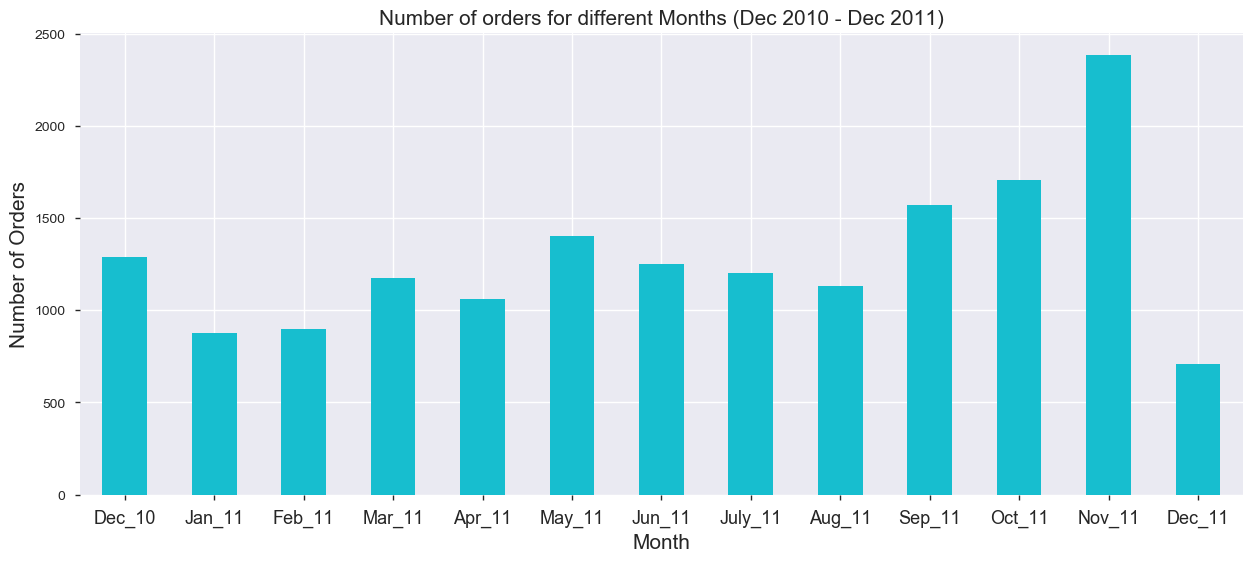

In [34]:
ax = df2.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot('bar',color=color[9],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

In [35]:
Number_Orders = df2.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index()
Number_Orders

[201012]    1291
[201101]     874
[201102]     896
[201103]    1177
[201104]    1058
[201105]    1403
[201106]    1249
[201107]    1200
[201108]    1133
[201109]    1568
[201110]    1705
[201111]    2386
[201112]     706
Name: year_month, dtype: int64

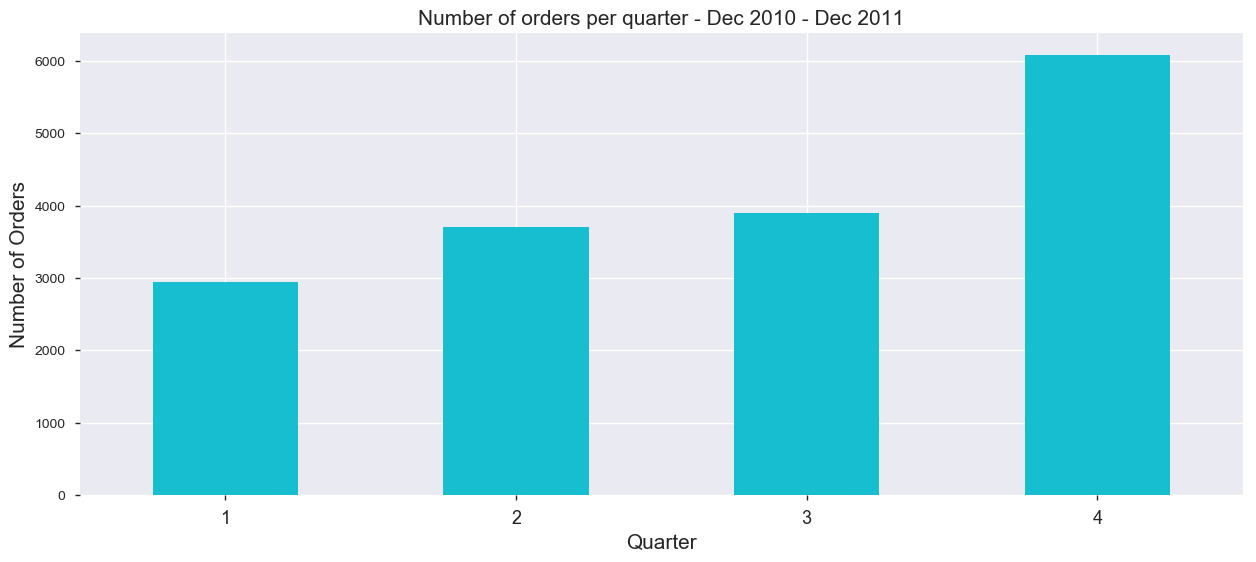

In [36]:
ax = df2.groupby('InvoiceNo')['quarter'].unique().value_counts().sort_index().plot('bar',color=color[9],figsize=(15,6))
ax.set_xlabel('Quarter',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders per quarter - Dec 2010 - Dec 2011',fontsize=15)
ax.set_xticklabels(('1','2','3','4'), rotation='horizontal', fontsize=13)


plt.show()

In [37]:
Number_Orders = df2.groupby('InvoiceNo')['quarter'].unique().value_counts().sort_index()
Number_Orders

[1]    2947
[2]    3710
[3]    3901
[4]    6088
Name: quarter, dtype: int64

#### The distribution of sales during the days of week is uniform with mid week days of Wed and Thurs hitting the peaks on an average. Sales tends to increase from Monday to Thursday and then falls on the next two days.
#### Interestingly there are no transactions on Saturdays!!!

In [39]:
OrdersPerDay = df2.groupby('InvoiceNo')['day'].unique().value_counts().sort_index()
OrdersPerDay

[1]    2553
[2]    2887
[3]    3091
[4]    3599
[5]    2478
[7]    2038
Name: day, dtype: int64

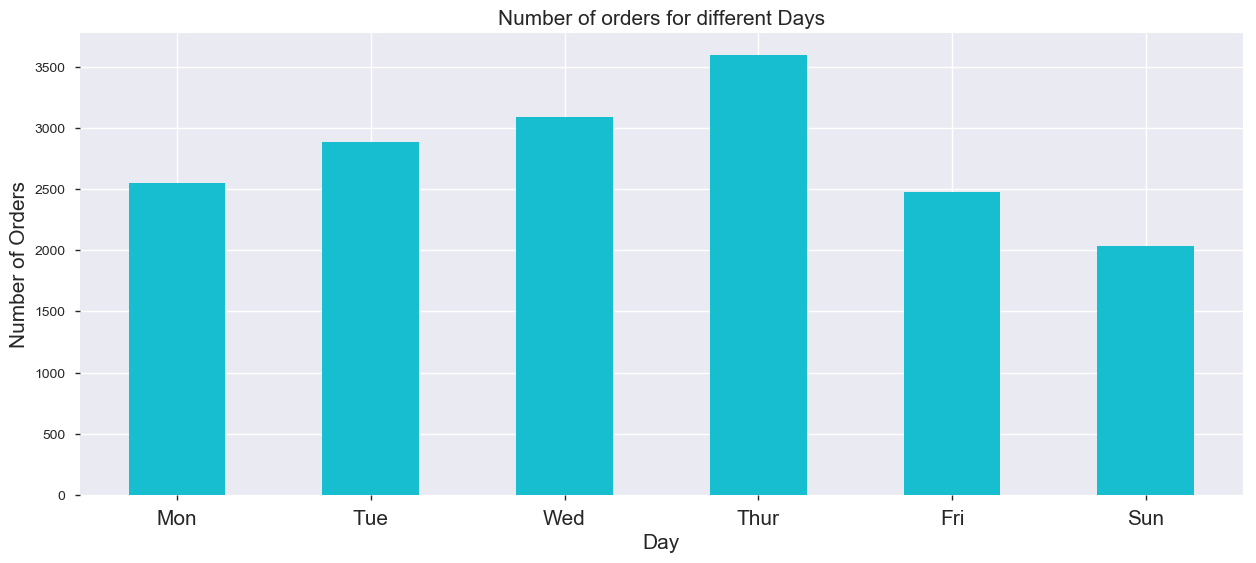

In [40]:
ax = OrdersPerDay.plot('bar',color=color[9],figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

#### The Sales during the mid day seems to be the peak time.
#### 10 AM to 5 PM seems to be busy hours with 12 noon to 1 PM being the busiest. Majority of Sales occurs during the office hours.
#### Strangely for an online store, the sales closes at around 8 PM. Is this a case of data loss or is it the true situation with the store?

In [42]:
OrderPerHour = df2.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index()
OrderPerHour

[6]        1
[7]       23
[8]      452
[9]     1195
[10]    1934
[11]    2077
[12]    2865
[13]    2382
[14]    2034
[15]    1853
[16]    1022
[17]     494
[18]     158
[19]     137
[20]      18
Name: hour, dtype: int64

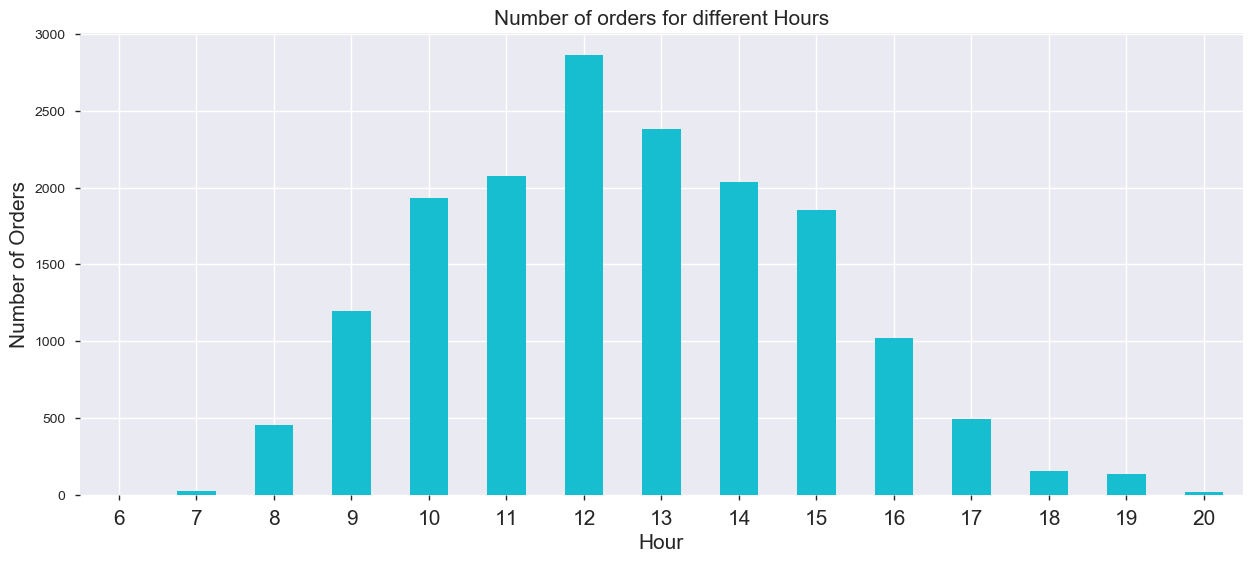

In [43]:
ax = OrderPerHour.plot('bar',color=color[9],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

#### Frequency of Day of week vs Hour of day can be seen in chart below.
#### White spaces are the times with no sales.
#### Light Cream color cells are the hours/days with highest sales or busiest hours of the week on an average.

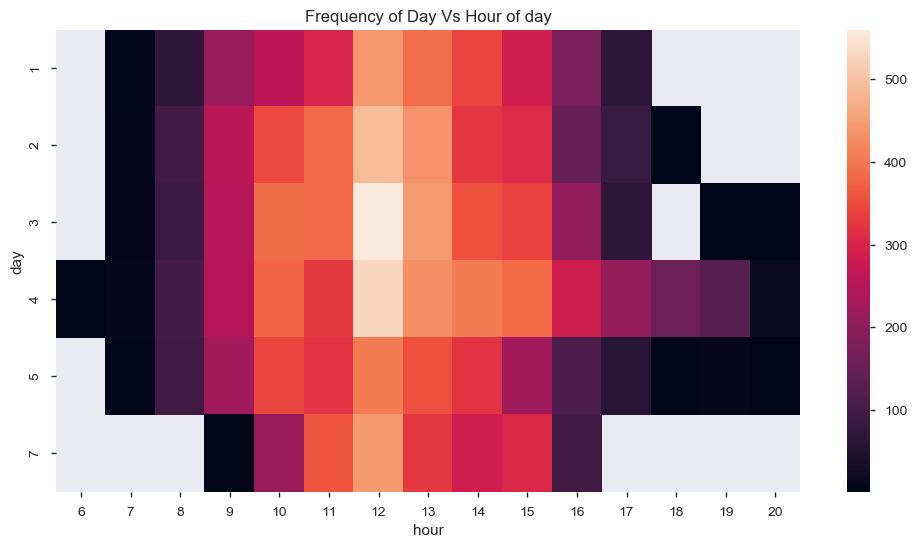

In [44]:
grouped_df  = df2.groupby(["day", "hour"])["InvoiceNo"].unique().reset_index()
grouped_df["InvoiceNo"] = grouped_df["InvoiceNo"].apply(len)

#grouped_df = df.groupby(["Weekday", "hour"])["InvoiceNo"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'InvoiceNo')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day Vs Hour of day")
plt.show()

### Total Sales (First order vs Reorder)

In [45]:
df_sort = df2.sort_values(['CustomerID', 'StockCode', 'InvoiceDate'])
df_sort_shift1 = df_sort.shift(1)
df_sort_reorder = df_sort.copy()
df_sort_reorder['reorder'] = np.where(df_sort['StockCode'] == df_sort_shift1['StockCode'], 1,0)
df_sort_reorder.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,year_month,month,quarter,day,hour,Week,datepart,Year,UnitPrice,Revenue,CustomerID,Country,reorder
32813,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,201101,1,1,2,10,03,18,2011,1.04,77183.60,12346,United Kingdom,0
59460,545321,20711,JUMBO BAG TOYS,20,2011-03-01 14:53:00,201103,3,1,2,14,09,01,2011,1.95,39.00,12747,United Kingdom,0
6629,537215,21136,PAINTED METAL PEARS ASSORTED,8,2010-12-05 15:38:00,201012,12,4,7,15,48,05,2010,1.69,13.52,12747,United Kingdom,0
34235,541677,21136,PAINTED METAL PEARS ASSORTED,16,2011-01-20 14:01:00,201101,1,1,4,14,03,20,2011,1.69,27.04,12747,United Kingdom,1
59469,545321,21136,PAINTED METAL PEARS ASSORTED,16,2011-03-01 14:53:00,201103,3,1,2,14,09,01,2011,1.69,27.04,12747,United Kingdom,1


### Top 10 Reorder item

In [46]:
pd.DataFrame((df_sort_reorder.groupby(['Description'])['reorder'].sum())).sort_values('reorder', ascending = False).head(10)

,reorder
Description,
WHITE HANGING HEART T-LIGHT HOLDER,1108
JUMBO BAG RED RETROSPOT,899
LUNCH BAG RED RETROSPOT,681
ASSORTED COLOUR BIRD ORNAMENT,678
REGENCY CAKESTAND 3 TIER,650
PARTY BUNTING,641
LUNCH BAG BLACK SKULL.,596
LUNCH BAG SUKI DESIGN,566
JUMBO BAG PINK POLKADOT,485


### Sales by Month

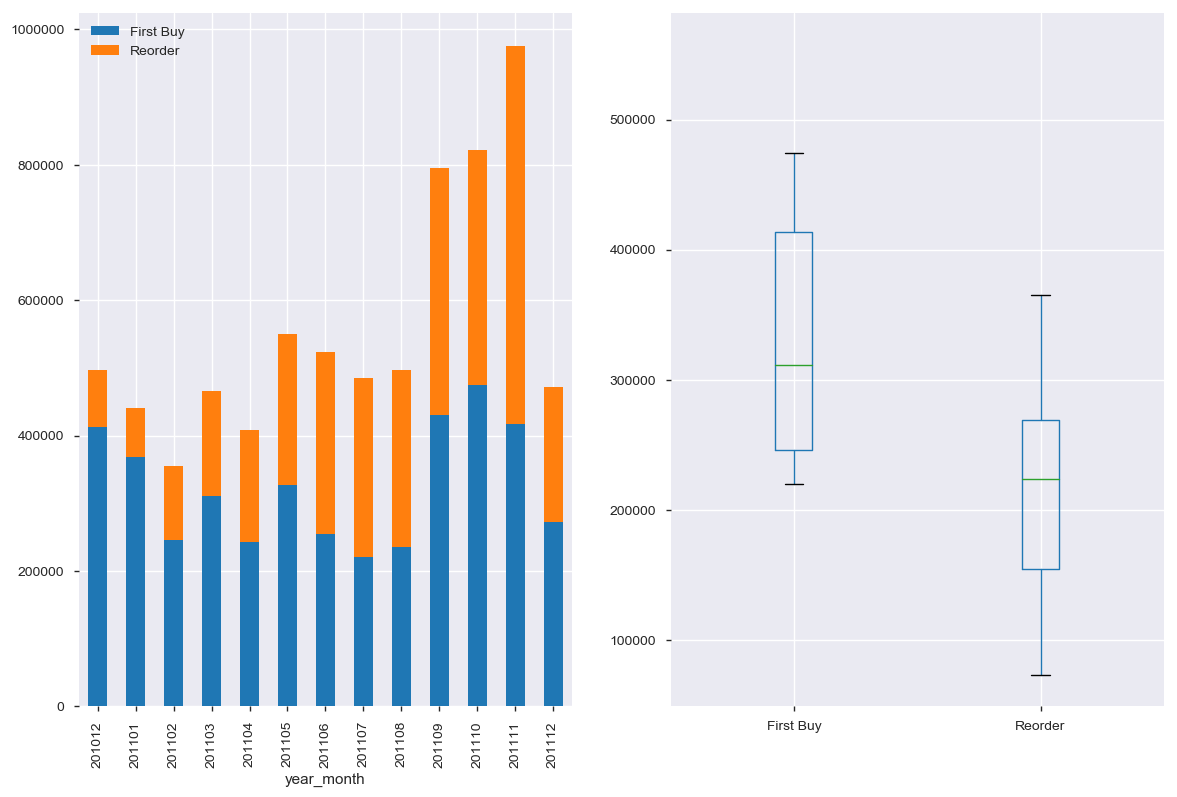

In [47]:
notreorder = (df_sort_reorder[df_sort_reorder['reorder'] == 0 ].groupby(['year_month'])['Revenue'].sum())
reorder = (df_sort_reorder[df_sort_reorder['reorder'] == 1 ].groupby(['year_month'])['Revenue'].sum())

yearmonth = pd.DataFrame([notreorder , reorder], index=['First Buy', 'Reorder']).transpose()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,9))

yearmonth.plot.bar(stacked=True, ax=axes[0])
yearmonth.plot.box(ax=axes[1])

### Sales by Week

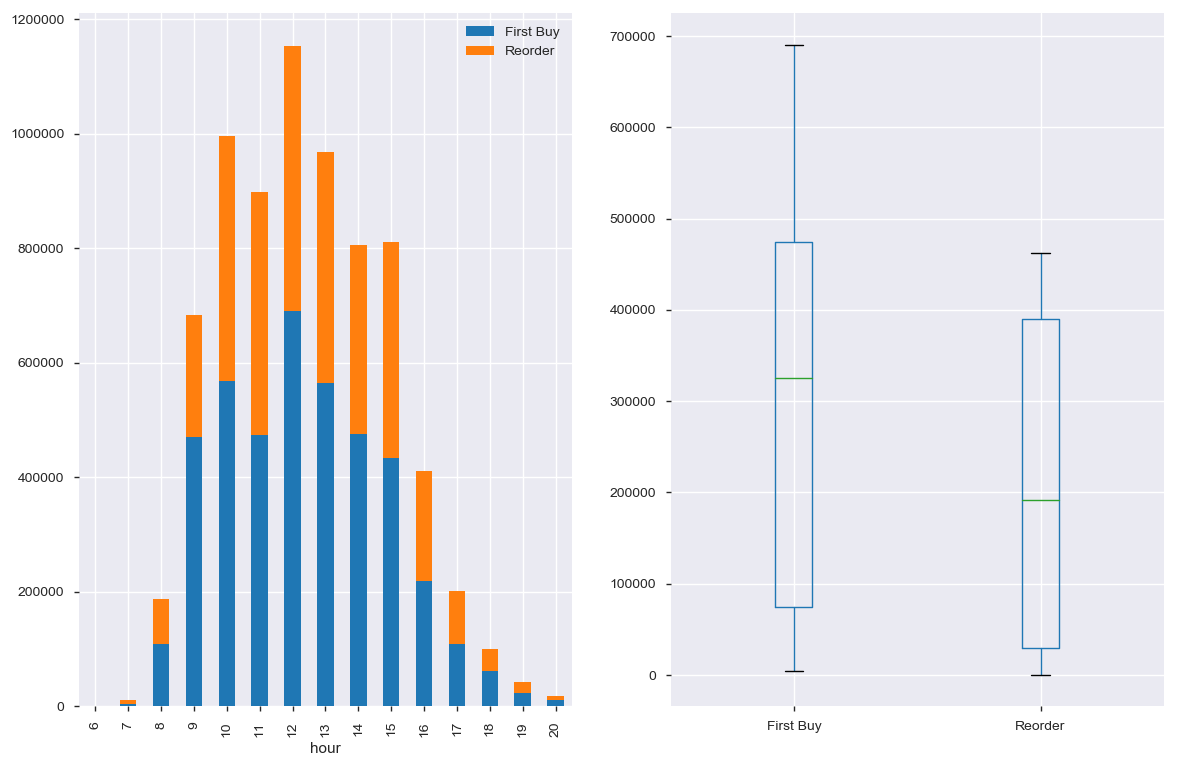

In [48]:
notreorder = (df_sort_reorder[df_sort_reorder['reorder'] == 0 ].groupby(['hour'])['Revenue'].sum())
reorder = (df_sort_reorder[df_sort_reorder['reorder'] == 1 ].groupby(['hour'])['Revenue'].sum())

yearmonth = pd.DataFrame([notreorder , reorder], index=['First Buy', 'Reorder']).transpose()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,9))

yearmonth.plot.bar(stacked=True, ax=axes[0])
yearmonth.plot.box(ax=axes[1])

### Sales by date_of_month

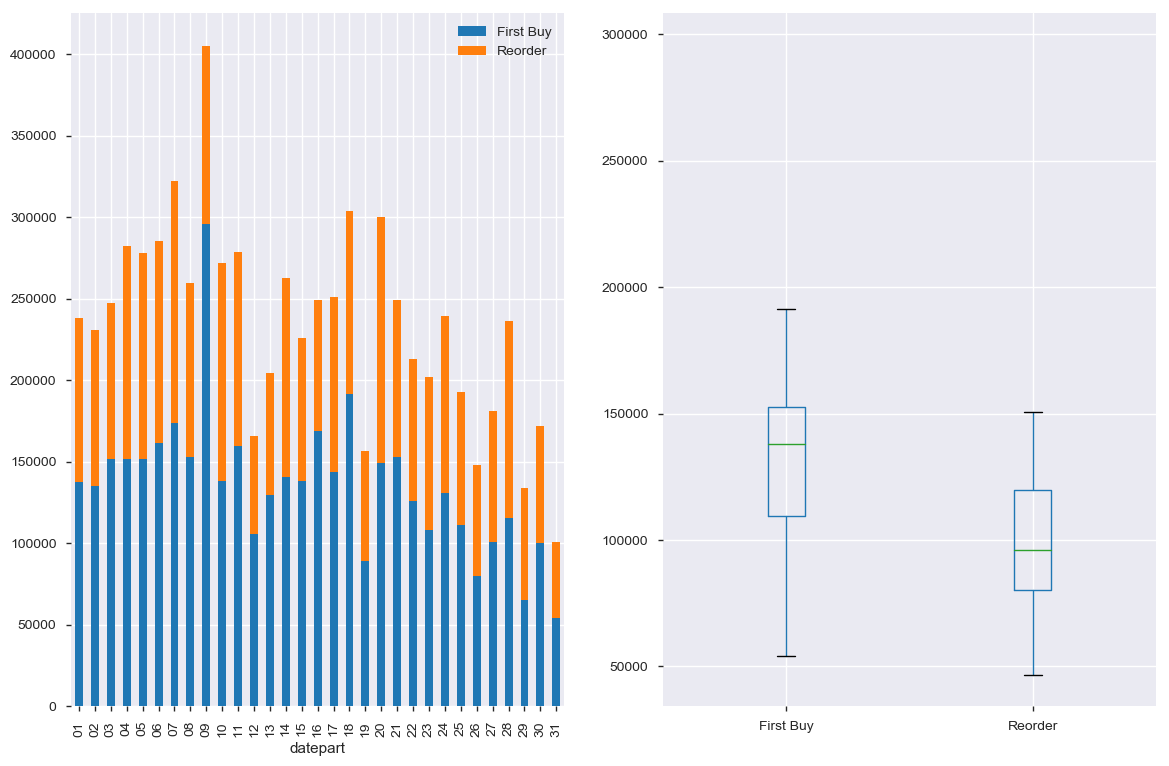

In [50]:
notreorder = (df_sort_reorder[df_sort_reorder['reorder'] == 0 ].groupby(['datepart'])['Revenue'].sum())
reorder = (df_sort_reorder[df_sort_reorder['reorder'] == 1 ].groupby(['datepart'])['Revenue'].sum())

yearmonth = pd.DataFrame([notreorder , reorder], index=['First Buy', 'Reorder']).transpose()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,9))

yearmonth.plot.bar(stacked=True, ax=axes[0])
yearmonth.plot.box(ax=axes[1])

## Building a Customer Database

#### Customer Database with details such as First Order Date, Last Order Date, Days as Customer, Days since last order gives us readymade access to individual customer level information which after clustering or building a segmentation model can be used for Customer engagement activities, customer profiling etc.

In [51]:
earliest_order = df2.groupby(by='CustomerID', as_index=False)['InvoiceDate'].min()
earliest_order.columns = ['CustomerID', 'EarliestInvoice']
earliest_order['now'] = pd.to_datetime((df['InvoiceDate']).max())
earliest_order['days_as_customer'] = 1 + (earliest_order.now-earliest_order.EarliestInvoice).astype('timedelta64[D]')
earliest_order.drop('now', axis=1, inplace=True)
earliest_order

,CustomerID,EarliestInvoice,days_as_customer
0,12346,2011-01-18 10:01:00,326.0
1,12747,2010-12-05 15:38:00,369.0
2,12748,2010-12-01 12:48:00,374.0
3,12749,2011-05-10 15:25:00,213.0
4,12820,2011-01-17 12:34:00,327.0
5,12821,2011-05-09 15:51:00,214.0
6,12822,2011-09-13 13:46:00,87.0
7,12823,2011-02-16 12:15:00,297.0
8,12824,2011-10-11 12:49:00,60.0
9,12826,2010-12-09 15:21:00,365.0


In [52]:
last_order = df2.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
last_order.columns = ['CustomerID', 'last_purchase']
last_order['now'] = pd.to_datetime((df['InvoiceDate']).max())
last_order['days_since_purchase'] = 1 + (last_order.now-last_order.last_purchase).astype('timedelta64[D]')
last_order.drop('now', axis=1, inplace=True)
last_order

,CustomerID,last_purchase,days_since_purchase
0,12346,2011-01-18 10:01:00,326.0
1,12747,2011-12-07 14:34:00,2.0
2,12748,2011-12-09 12:20:00,1.0
3,12749,2011-12-06 09:56:00,4.0
4,12820,2011-12-06 15:12:00,3.0
5,12821,2011-05-09 15:51:00,214.0
6,12822,2011-09-30 10:04:00,71.0
7,12823,2011-09-26 07:35:00,75.0
8,12824,2011-10-11 12:49:00,60.0
9,12826,2011-12-07 10:25:00,3.0


#### Number of orders per customer

In [53]:
invoice_ct = df2.groupby(by='CustomerID', as_index=False).agg({'InvoiceNo': pd.Series.nunique})
invoice_ct.columns = ['CustomerID', 'NumberOrders']
invoice_ct

,CustomerID,NumberOrders
0,12346,1
1,12747,11
2,12748,209
3,12749,5
4,12820,4
5,12821,1
6,12822,2
7,12823,5
8,12824,1
9,12826,7


#### On an average customers order 5 times a year.

In [54]:
invoice_ct.describe()

,CustomerID,NumberOrders
count,3920.000000,3920.000000
mean,15562.059694,4.246429
std,1576.594671,7.199202
min,12346.000000,1.000000
25%,14208.750000,1.000000
50%,15569.500000,2.000000
75%,16913.250000,5.000000
max,18287.000000,209.000000


#### The below two snippet gives an idea of how much money have the customers spent over last one year and total items bought.

In [55]:
total_spend = df2.groupby(by='CustomerID', as_index=False)['Revenue'].sum()
total_spend.columns = ['CustomerID', 'total_spent']
total_spend

,CustomerID,total_spent
0,12346,77183.60
1,12747,4196.01
2,12748,33053.19
3,12749,4090.88
4,12820,942.34
5,12821,92.72
6,12822,948.88
7,12823,1759.50
8,12824,397.12
9,12826,1474.72


In [56]:
total_items = df2.groupby(by='CustomerID', as_index=False)['Quantity'].sum()
total_items.columns = ['CustomerID', 'NumberItems']
total_items

,CustomerID,NumberItems
0,12346,74215
1,12747,1275
2,12748,25287
3,12749,1471
4,12820,722
5,12821,70
6,12822,550
7,12823,230
8,12824,232
9,12826,1058


#### Combine all the above individual tables and build a hughe Customer Database

In [57]:
import functools
dfs = [total_spend,invoice_ct,earliest_order,last_order,total_items]
CustomerTable = functools.reduce(lambda left,right: pd.merge(left,right,on='CustomerID', how='outer'), dfs)
CustomerTable.head()

,CustomerID,total_spent,NumberOrders,EarliestInvoice,days_as_customer,last_purchase,days_since_purchase,NumberItems
0,12346,77183.60,1,2011-01-18 10:01:00,326.0,2011-01-18 10:01:00,326.0,74215
1,12747,4196.01,11,2010-12-05 15:38:00,369.0,2011-12-07 14:34:00,2.0,1275
2,12748,33053.19,209,2010-12-01 12:48:00,374.0,2011-12-09 12:20:00,1.0,25287
3,12749,4090.88,5,2011-05-10 15:25:00,213.0,2011-12-06 09:56:00,4.0,1471
4,12820,942.34,4,2011-01-17 12:34:00,327.0,2011-12-06 15:12:00,3.0,722


In [58]:
CustomerTable.describe()

,CustomerID,total_spent,NumberOrders,days_as_customer,days_since_purchase,NumberItems
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,1858.424654,4.246429,223.553571,92.208418,1081.965561
std,1576.594671,7478.631256,7.199202,118.070706,99.533854,3734.328588
min,12346.000000,3.750000,1.000000,1.000000,1.000000,1.000000
25%,14208.750000,298.185000,1.000000,112.000000,18.000000,153.000000
50%,15569.500000,644.975000,2.000000,249.000000,51.000000,364.500000
75%,16913.250000,1571.285000,5.000000,327.000000,143.000000,945.000000
max,18287.000000,259657.300000,209.000000,374.000000,374.000000,80997.000000


#### Lets identify and separate big spenders, lots of orders, long-time customers, dormant customers for sales and marketing campaigns.

In [59]:
def big_spender(row):
    if row['total_spent'] >= 1661.64:
        return 'Yes'
    else:
        return 'No'

def many_orders(row):
    if row['NumberOrders'] >= 100:
        return 'Yes'
    else:
        return 'No'

def loyal_customer(row):
    if row['days_as_customer'] >= 326:
        return 'Yes' 
    else:
        return 'No'

def dormant_customer(row):
    if row['days_since_purchase'] >= 141:
        return 'Yes' 
    else:
        return 'No'

CustomerTable['BigSpender'] = CustomerTable.apply(big_spender, axis=1)
CustomerTable['ManyOrders'] = CustomerTable.apply(many_orders, axis=1)
CustomerTable['LoyalCustomer'] = CustomerTable.apply(loyal_customer, axis=1)
CustomerTable['DormantCustomer'] = CustomerTable.apply(dormant_customer, axis=1)
CustomerTable['OrderFrequency'] = CustomerTable['NumberOrders']/CustomerTable['days_as_customer']

CustomerTable.head(10)

,CustomerID,total_spent,NumberOrders,EarliestInvoice,days_as_customer,last_purchase,days_since_purchase,NumberItems,BigSpender,ManyOrders,LoyalCustomer,DormantCustomer,OrderFrequency
0,12346,77183.60,1,2011-01-18 10:01:00,326.0,2011-01-18 10:01:00,326.0,74215,Yes,No,Yes,Yes,0.003067
1,12747,4196.01,11,2010-12-05 15:38:00,369.0,2011-12-07 14:34:00,2.0,1275,Yes,No,Yes,No,0.029810
2,12748,33053.19,209,2010-12-01 12:48:00,374.0,2011-12-09 12:20:00,1.0,25287,Yes,Yes,Yes,No,0.558824
3,12749,4090.88,5,2011-05-10 15:25:00,213.0,2011-12-06 09:56:00,4.0,1471,Yes,No,No,No,0.023474
4,12820,942.34,4,2011-01-17 12:34:00,327.0,2011-12-06 15:12:00,3.0,722,No,No,Yes,No,0.012232
5,12821,92.72,1,2011-05-09 15:51:00,214.0,2011-05-09 15:51:00,214.0,70,No,No,No,Yes,0.004673
6,12822,948.88,2,2011-09-13 13:46:00,87.0,2011-09-30 10:04:00,71.0,550,No,No,No,No,0.022989
7,12823,1759.50,5,2011-02-16 12:15:00,297.0,2011-09-26 07:35:00,75.0,230,Yes,No,No,No,0.016835
8,12824,397.12,1,2011-10-11 12:49:00,60.0,2011-10-11 12:49:00,60.0,232,No,No,No,No,0.016667
9,12826,1474.72,7,2010-12-09 15:21:00,365.0,2011-12-07 10:25:00,3.0,1058,No,No,Yes,No,0.019178


#### With the help of the above database we can create a segment of Customers and  target or deal with each segment.
#### Dormant Customers can be targetted by sending them some kind of discounts or coupons which would attract them to buy something from the website. They are the customers at risk for the company. Send them personalized emails to encourage them to shop.

#### Loyal Customers are the Champions. So reward them. They can be early adopters to new products. Try recommending new products to Loyal Customers and Big Spenders. Suggest them "Refer a friend" and provide incentives.

#### Distribution Plots - study the relationships with other continuous variables

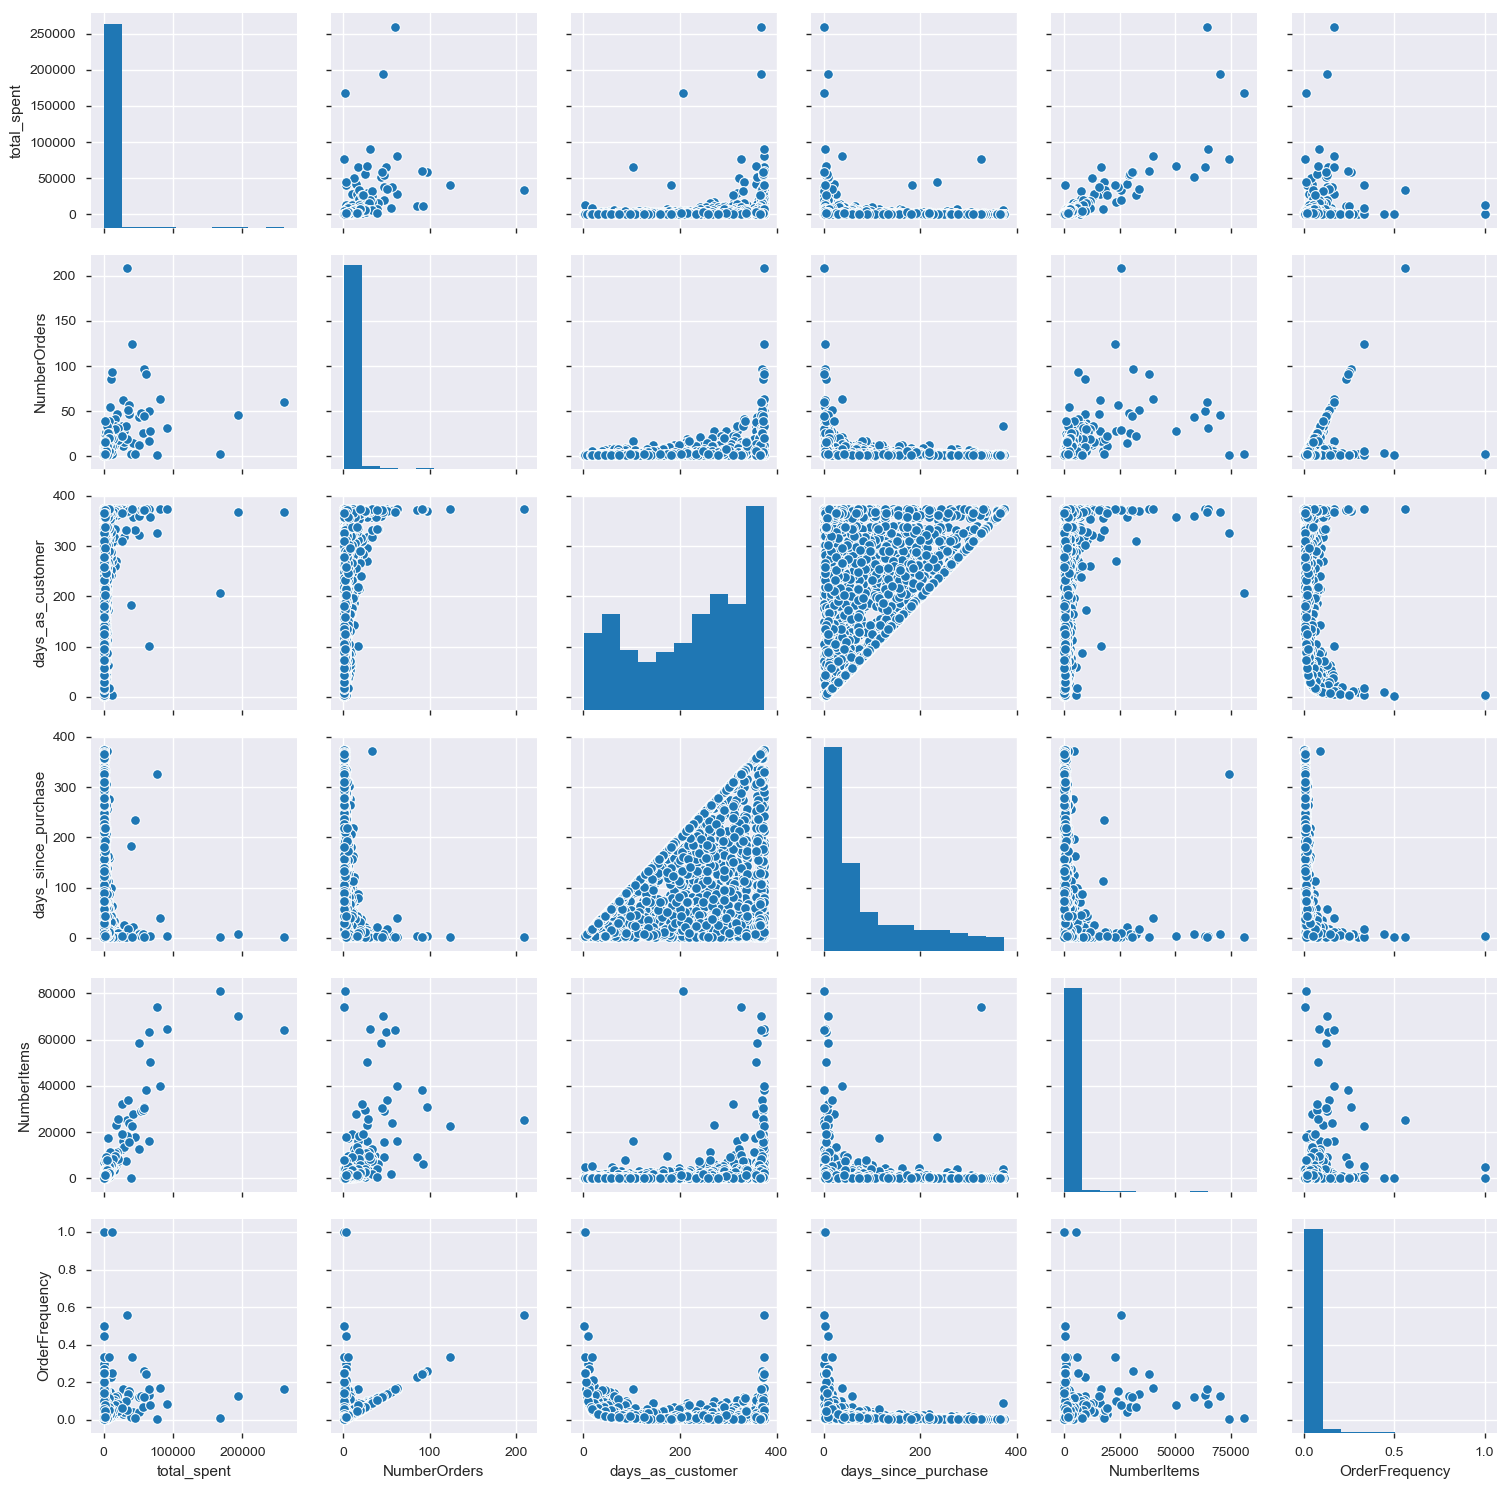

In [60]:
sns.pairplot(CustomerTable, vars=["total_spent", "NumberOrders",'days_as_customer',
                                  'days_since_purchase','NumberItems','OrderFrequency'])

#### What are the top words from the item description that is appearing in most of the transactions? This gives us a perception of the sales trends and also most sold products.

In [61]:
MostSoldProduct = df2.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
MSP = MostSoldProduct.head(10)
MSP

,StockCode,Description,Quantity
2587,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2089,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
3005,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49086
3427,85099B,JUMBO BAG RED RETROSPOT,41878
3442,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34630
3262,84879,ASSORTED COLOUR BIRD ORNAMENT,32628
1104,22197,POPCORN HOLDER,28923
1499,22616,PACK OF 12 LONDON TISSUES,24321
77,17003,BROCADE RING PURSE,22675
429,21212,PACK OF 72 RETROSPOT CAKE CASES,22442


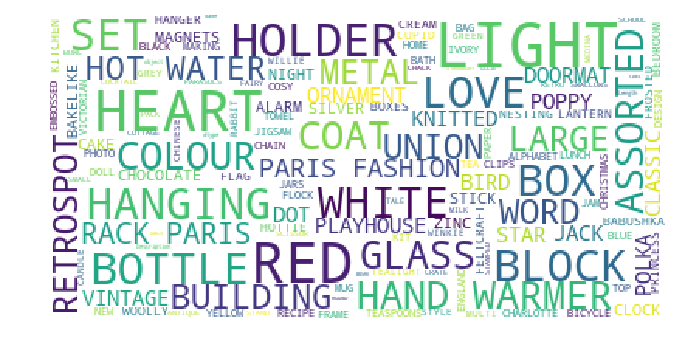

In [62]:
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df2['Description']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("itemDescriptionCloud.png", dpi=900)

## Top 5 Customers

In [63]:
orders = df2.groupby(by=['CustomerID'], as_index=False).agg({'InvoiceNo': pd.Series.nunique, "Revenue": "sum"})
print('The TOP 5 customers with most number of orders...')
MostOrders=orders.sort_values(by=['InvoiceNo'], ascending=False).head()
MostOrders

The TOP 5 customers with most number of orders...


,CustomerID,InvoiceNo,Revenue
2,12748,209,33053.19
3593,17841,124,40519.84
191,13089,97,58762.08
1267,14606,93,12076.15
1771,15311,91,60632.75


In [64]:
money_spent = df2.groupby(by=['CustomerID'], as_index=False).agg({'InvoiceNo': pd.Series.nunique, "Revenue": "sum"})
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='Revenue', ascending=False).head()

The TOP 5 customers with highest money spent...


,CustomerID,InvoiceNo,Revenue
3783,18102,60,259657.30
3314,17450,46,194390.79
2598,16446,2,168472.50
3356,17511,31,91062.38
2294,16029,63,80850.84


In [65]:
invoice_ct.NumberOrders.describe()

count    3920.000000
mean        4.246429
std         7.199202
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: NumberOrders, dtype: float64

The average number of orders per customer is 4 to 5.

In [66]:
groupby_invoice = pd.DataFrame(df2.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns=['productsNumber']
groupby_invoice.describe()

,productsNumber
count,16646.000000
mean,20.691758
std,23.946498
min,1.000000
25%,6.000000
50%,15.000000
75%,27.000000
max,541.000000


From the above table, the average number of unique items per order is 21.

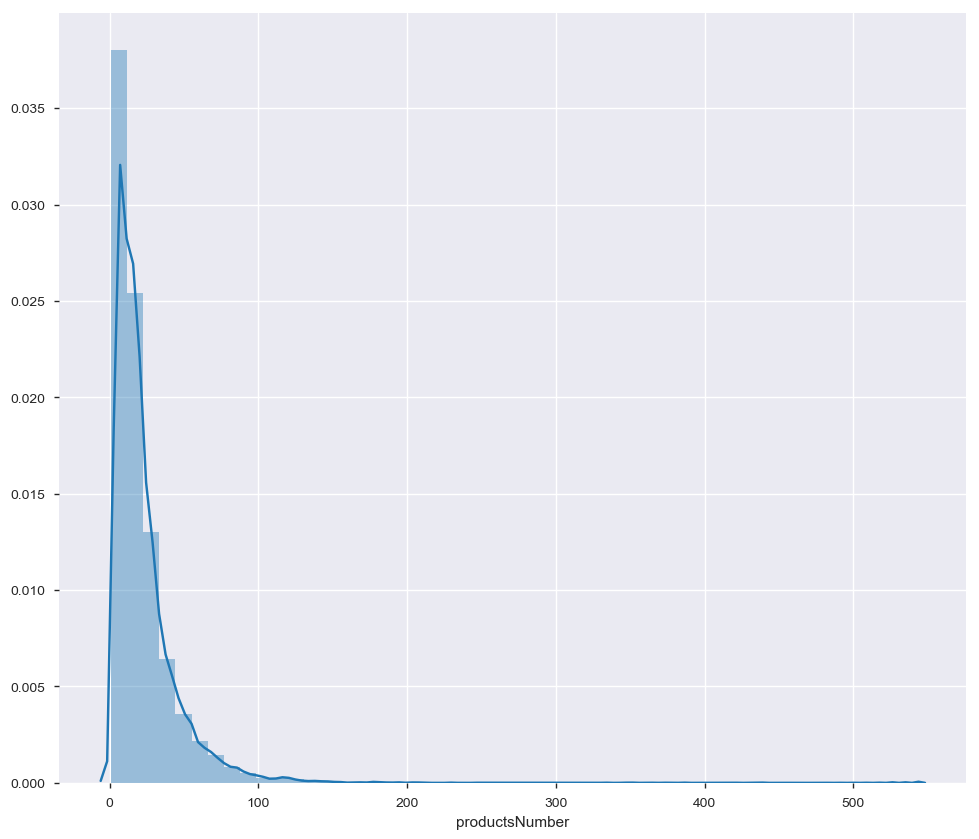

In [67]:
#Visualize the variable productsNumber distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.distplot(groupby_invoice['productsNumber'],ax=ax)
plt.show()

From the above visual we can conclude that people buy less than 25 to 35 items on an avg in a single order.

## Customer Segmentation by Clustering Analysis

In [68]:
data_grouped = df2.groupby('CustomerID')
data_cluster=pd.DataFrame(columns=['Quantity','UnitPrice', 'Revenue', 'CustomerID'])
count=0

In [70]:
for k,v in (data_grouped):
    data_cluster.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), v['Revenue'].sum(), k]
    count+=1

# Applying K-Means Clustering Algorithm to quantity, and total spend
X = data_cluster.iloc[:, [0, 2]].values

In [71]:
data_cluster.head()

,Quantity,UnitPrice,Revenue,CustomerID
0,74215.0,1.04,77183.60,12346.0
1,1275.0,449.89,4196.01,12747.0
2,25287.0,11788.31,33053.19,12748.0
3,1471.0,994.99,4090.88,12749.0
4,722.0,112.38,942.34,12820.0


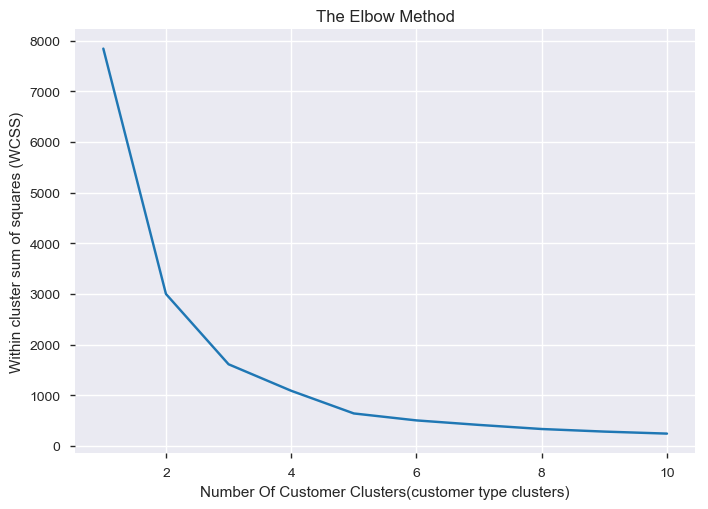

In [72]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

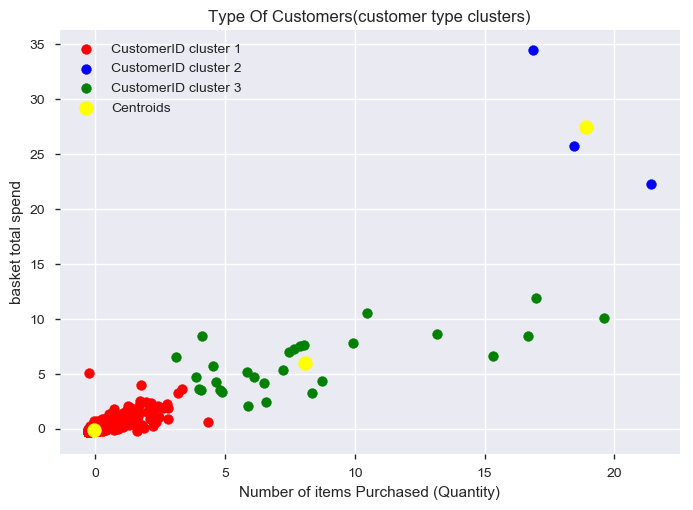

In [73]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
plt.legend()
plt.show()

#### Clustering algorithm appears to separate the customers based on numbers of items and total spend. Red cluster is the customer who spend less and green is mid to high spend cluster of customers.  Blue seems to be kind of an outlier.
#### By employing a better feature engineering techniques we can improve this model.

### Section 2: Summary/ Write-up Section

Although there are different ways to reach the customers, the best way is to know who are your customers and your marketing campaigns should target the appropriate users to maximize on the profits or conversions per ad/effort.

In this case, it is mentioned that the users are wholesale dealers and hence it proves that the users buy products in bulk and resell them in a different channel. It is apparent from the buying pattern in term of time and days that the buyers are employees of other wholesale dealers. So nurture free trial prospects and get them to upgrade their membership. Also it would be smart to screen our ads between 10 AM to 5 PM everyday except on Saturday as there are no sales on Saturdays in the last one year.

The way you treat your customers matters. Are you giving them a good experience? Because Word of Mouth advertising is the most important means of reaching out to new set of customers and growing the user base. According to Verint, 61% of consumers would tell friends and family about their experiences, while 27% reported that they would sign up to the company’s loyalty scheme. So getting a very good customer feedbacks, Stars and comments on the website/App is very important.

* I would recommend to use social media as an engagement tool and not simply a ad platform. 
* Digital marketing can also be done by engaging customers with In-Product messaging.
* Since we saw a great shift in sales during a particular hour of the day, it is best to do A/B testing with the website/application and get more insights from the test and plan the strategy.
* Non-Brand Paid Search is one more great way of online advertising.

We can use any means of digital marketing with a clearly define goals and proper analysis based on the data collected from various marketing metrics during the period of campaigning. The end result should be that it should grab a lot of eye balls. If its a SEO or SEM, then monitor the Click through rate, Clicks, Visit Conversion regularly. I would try to keep Cost/Click to as low as possible.


There are about 16% of cancelled orders in the dataset. It will defintely be worthy to analyse the cancelled orders and see if you can uncover any pattern and get the reasons for cancellation. Is it the product or the service that is the prime reason for 16% cancellations? This analysis results would certainly help in understanding the areas we should improve.

Customers place more orders in the second half of the year. Nov is the month with highest orders followed by Oct and Sept. Since we do not have full Dec month's data for both 2010 and 2011 let us also not discount the performance during the last month of both the years. Infact year end surge in the sales is one more indicator to stock up the fast moving items before the shopping season start sometime around Sept/Oct and Thanksgiving period. So it time to analyse and decide as a team if running a promotions and discounts during the months of Jan and Feb to kickstart the year with great offers and attract the customers, thereby boosting the sales of Q1.

Likewise, the weekly sales trends has a very interesting pattern that increases from Monday to Thursday and then falls during the next two days. Interestingly there are no transactions on Saturdays!!! It would not be a bad idea to run some ads on Friday whole day and also start some sorts of promotional offers on weekends to boost the weekend sales.

On an average a customer order 5 times a year. Try to improve the average by sending personalized emails to the customers after fulfilling each and every order and provide a discount code with a small validity date which might attract them to come back again and purchase something else with the coupon.

Dormant Customers can be targetted by sending them some kind of discounts or coupons which would attract them to buy something from the website. They are the customers at risk for the company. Send them personalized emails to encourage them to shop.

Loyal Customers are the Champions. So reward them. They can be early adopters to new products. Try recommending new products to Loyal Customers and Big Spenders. Suggest them "Refer a friend" and provide incentives.

Analysis tells that people buy less than 25 to 35 items on an avg in a single order. To improve this, running a marketing campaign and giving 'free shipping for over 30 products' kind of offers might attract the users to buy more in a single transaction which would help in increasing the revenue and units per transaction and thereby increasing the overall revenue.

We can certainly perform Cohort Analysis/RFM Analysis which answers these questions:
* Who are our best customers?
* Who has the potential to be converted in more profitable customers?
* Which customers we must retain?
* Which group of customers is most likely to respond to our current campaign?

After performing the initial analysis, it makes sense to show interested stakeholders the analysis and get their input. The decision should be based upon how the business plans to use the results, and the level of granularity we want to see in the clusters/segments. What range of customer behavior from high-to-low value customers are we interested in exploring? And from the answer to that question various methods of clustering can be further exploited whether applied on RFM variables or directly on the transaction dataset available.

Building a visualization/dashboard in Tableau would have been my next step which can help us determine any other patterns and provides us a better picture visually.

My next steps after that in this analysis would have been performing better feature engineering, building predictive modelling and Classification for future customers in appropriate defined clusters by trying different models like Random Forest, Logistic Regression on training set and compare their performance on the test set in order to choose the best one to use for our predictions.

#### END OF NOTEBOOK